In [1]:
!pip install kaggle
!kaggle datasets download -d guare13/handwritten-letters-recognition
!unzip handwritten-letters-recognition.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: valid_letters/letter_3363.png  
  inflating: valid_letters/letter_33630.png  
  inflating: valid_letters/letter_33631.png  
  inflating: valid_letters/letter_33632.png  
  inflating: valid_letters/letter_33633.png  
  inflating: valid_letters/letter_33634.png  
  inflating: valid_letters/letter_33635.png  
  inflating: valid_letters/letter_33636.png  
  inflating: valid_letters/letter_33637.png  
  inflating: valid_letters/letter_33638.png  
  inflating: valid_letters/letter_33639.png  
  inflating: valid_letters/letter_3364.png  
  inflating: valid_letters/letter_33640.png  
  inflating: valid_letters/letter_33641.png  
  inflating: valid_letters/letter_33642.png  
  inflating: valid_letters/letter_33643.png  
  inflating: valid_letters/letter_33644.png  
  inflating: valid_letters/letter_33645.png  
  inflating: valid_letters/letter_33646.png  
  inflating: valid_letters/letter_33648.png  
  inflating: valid_le

In [3]:
import torch
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
import shutil
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

In [4]:
train = pd.read_csv('written_letters_train.csv')
validation = pd.read_csv('written_letters_validation.csv')

In [5]:
characters = sorted(set("".join(train['nombre'].astype(str))))
char_to_label = {char: idx for idx, char in enumerate(characters)}
label_to_char = {idx: char for char, idx in char_to_label.items()}

In [6]:
path_val = "valid_letters"
path_test = "test_letters"
path_train = "train_letters"

In [7]:
class DataGenerator(Dataset):
    def __init__(self, dataframe, path, char_map, img_size=(14, 10), transform=None):
        self.dataframe = dataframe
        self.path = path
        self.char_map = char_map
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe['id'].values[idx]
        img = cv2.imread(os.path.join(self.path, img_path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0
        if self.transform:
            img = self.transform(img)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

        text = str(self.dataframe['nombre'].values[idx])
        label = torch.tensor([self.char_map[char] for char in text], dtype=torch.long)
        return img, label

In [8]:
# Transformación para las imágenes
transform = transforms.Compose([
    transforms.ToTensor()
])

In [9]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_val,char_to_label)

In [10]:
train_loader = DataLoader(train_generator, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_generator, batch_size=128, shuffle=False)

In [12]:
# Defineix el model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        """
        Entren imatges amb 3 canals de color (RGB) i amb aquesta capa convolucional
        s'estreuen característiques loclas de la imatge detectant patrons com bordes,
        textures i altres detalls que poden ser importants.
        """
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        """
        El max pooling redueix la dimensionalitat dels mapas de característiques,
        disminuint la mida de les imatges i retenint les característiques més importants
        Això ajuda a reduir el sobreajustament i millora l'eficàcia computacional.
        """
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = nn.Dropout(0.5)
        """
        Les següents dues capes s'ecarreguen de la classificació final. Transformen
        les característiques extretes per les capas convolucionals i de pooling a les
        propietats de les diferents classes (lletres).
        """
        self.fc1 = nn.Linear(16 * 7 * 5, 64)
        self.fc2 = nn.Linear(64, 29)  # 29 perquè hi ha 29 caràcters a l'alfabet

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 7 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Instancia el model, defineix la pèrdua i l'optimitzador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

/anaconda/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/15, Train Loss: 1.3104, Train Acc: 0.6504, Test Loss: 0.7554, Test Acc: 0.7980
Epoch 2/15, Train Loss: 0.6563, Train Acc: 0.8302, Test Loss: 0.6246, Test Acc: 0.8437
Epoch 3/15, Train Loss: 0.5659, Train Acc: 0.8584, Test Loss: 0.5559, Test Acc: 0.8617
Epoch 4/15, Train Loss: 0.5212, Train Acc: 0.8726, Test Loss: 0.5178, Test Acc: 0.8770
Epoch 5/15, Train Loss: 0.4928, Train Acc: 0.8813, Test Loss: 0.4985, Test Acc: 0.8846
Epoch 6/15, Train Loss: 0.4742, Train Acc: 0.8871, Test Loss: 0.4813, Test Acc: 0.8895
Epoch 7/15, Train Loss: 0.4593, Train Acc: 0.8906, Test Loss: 0.4738, Test Acc: 0.8897
Epoch 8/15, Train Loss: 0.4483, Train Acc: 0.8940, Test Loss: 0.4639, Test Acc: 0.8951
Epoch 9/15, Train Loss: 0.4387, Train Acc: 0.8967, Test Loss: 0.4523, Test Acc: 0.8965
Epoch 10/15, Train Loss: 0.4313, Train Acc: 0.8991, Test Loss: 0.4476, Test Acc: 0.8992
Epoch 11/15, Train Loss: 0.4237, Train Acc: 0.9010, Test Loss: 0.4443, Test Acc: 0.8993
Epoch 12/15, Train Loss: 0.4184, Train Ac

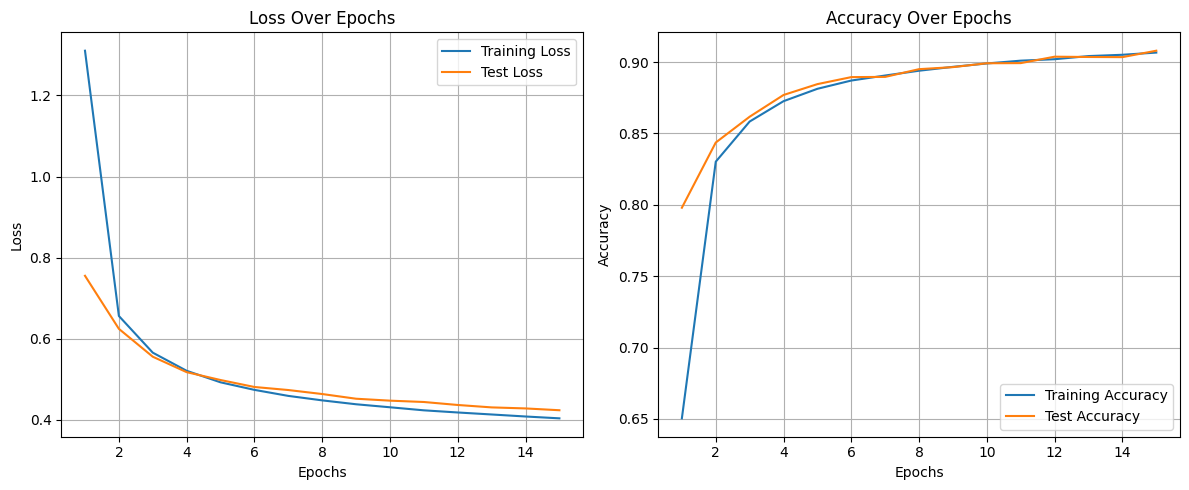

In [ ]:
# Entrenar el modelo
num_epochs = 15
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.view(-1)).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")

# Guardar el modelo entrenado
torch.save(model.state_dict(), 'simple_cnn_model.pth')

"""
# Crear la gráfica de pérdida y precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
"""

In [14]:
# Crear una instància del model
model = SimpleCNN()

# Carregar els pesos guardats
model.load_state_dict(torch.load('simple_cnn_model.pth'))
model.eval()  # Configurar el model en mode avaluació
print("Model carregat amb èxit de model_weights.pth")

Model carregat amb èxit de model_weights.pth


In [15]:
model.eval()
correct = 0
total = 0
validation_loss = 0.0

with torch.no_grad():
    for images, labels in validation_loader:
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels.view(-1))
        validation_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.view(-1)).sum().item()

accuracy = correct / total
validation_loss /= len(validation_loader)

print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Validation Loss: 0.3810, Validation Accuracy: 0.9160


In [16]:
!pip install kaggle
!kaggle datasets download -d landlord/handwriting-recognition
!unzip handwriting-recognition.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/V

In [53]:
train2 = pd.read_csv('written_name_train_v2.csv')
validation2 = pd.read_csv('written_name_validation_v2.csv')

In [55]:
train2.dropna(inplace=True)

In [56]:
train2['Length']=train2['IDENTITY'].apply(lambda x : len(str(x)))
train2=train2[train2['Length']<=21]
train2['IDENTITY']=train2['IDENTITY'].str.upper()
train2[train2['Length']==max(train2['Length'])]

,FILENAME,IDENTITY,Length
10278,TRAIN_10279.jpg,DOSSANTOS LASCONCELOS,21
108567,TRAIN_108568.jpg,O ZUARRDI EREBEVITRAC,21
156500,TRAIN_156501.jpg,ANDRIANNARISOA--DEGHI,21
160575,TRAIN_160576.jpg,LOUISIANE - EVANGELIN,21
174121,TRAIN_174122.jpg,GU ILLOSSOO - OARRIBA,21
212583,TRAIN_212584.jpg,DE MALEZIEUX DU HAMEL,21
220135,TRAIN_220136.jpg,COSTREL DE CORAINVILL,21
229529,TRAIN_229530.jpg,ROUSSEAV -- CHAUDIERE,21
230011,TRAIN_230012.jpg,BEKNARD DE LAVERNETTE,21
308769,TRAIN_308770.jpg,DATE NAISSANCE CLASSE,21


In [57]:
path_train2= 'train_v2/train'
path_validation2= 'validation_v2/validation'

In [205]:
import cv2
import numpy as np
import torch

def segment_letters(image_tensor, nom):
    trobat = False

    img = image_tensor.squeeze().numpy() * 255  # Convertir de tensor a imagen OpenCV
    img = img.astype('uint8')  # Asegurar que la imagen sea de tipo uint8
    if len(img.shape) == 2:  # Si la imagen es en escala de grises
        gray = img
    else:
        raise ValueError(f"Imagen con número de canales incorrecto: {len(img.shape)}")


    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    label_list = nom.flatten().tolist()
    print(label_list)

    zero_trobat = False
    label = []
    for num in label_list:
      if num != 0:
          label.append(num)
      elif num == 0 and not zero_trobat:
          label.append(num)
          zero_trobat = True
    label = label[:-1]

    if len(contours) == len(label):
        trobat = True

    letter_images = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        letter_images.append(torch.tensor(gray[y:y+h, x:x+w]))  # Convertir a tensor y añadir a la lista

    return letter_images, trobat



In [165]:
transform = transforms.Compose([
    transforms.Grayscale(),  # Convertir la imagen a escala de grises
    transforms.Resize((256, 64)),  # Cambiar el tamaño de la imagen
    transforms.ToTensor()  # Convertir la imagen a un tensor
])

In [192]:
class DataGenerator_img(Dataset):
    def __init__(self, dataframe, path, char_map, batch_size=128, img_size=(256, 64),
                 downsample_factor=4, max_length=22, shuffle=True, transform=None):
        self.dataframe = dataframe
        self.path = path
        self.char_map = char_map
        self.batch_size = batch_size
        self.width = img_size[0]
        self.height = img_size[1]
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.transform = transform
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return len(self.dataframe) // self.batch_size

    def __getitem__(self, idx):
        curr_batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = torch.zeros((self.batch_size, 1, self.height, self.width), dtype=torch.float32)
        batch_labels = torch.zeros((self.batch_size, self.max_length), dtype=torch.long)
        input_length = torch.ones((self.batch_size, 1), dtype=torch.float32) * (self.width // self.downsample_factor - 2)
        label_length = torch.zeros((self.batch_size, 1), dtype=torch.long)

        max_label_length = 0  # Para almacenar la longitud máxima de las etiquetas en el lote

        for i, idx in enumerate(curr_batch_idx):
            img_path = self.dataframe['FILENAME'].values[idx]
            img = cv2.imread(self.path + '/' + img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.width, self.height))  # Redimensionar a tamaño deseado
            img = img / 255.0  # Normalizar la imagen
            text = str(self.dataframe['IDENTITY'].values[idx])

            if self.transform:
                img = self.transform(img)

            img = torch.tensor(img, dtype=torch.float32)
            img = img.unsqueeze(0)  # Agregar dimensión del canal

            label = [self.char_map[char] for char in text]
            label_length[i] = len(label)  # Guardar la longitud de la etiqueta

            # Rellenar las etiquetas más cortas
            label.extend([0] * (self.max_length - len(label)))
            batch_labels[i] = torch.tensor(label, dtype=torch.long)

            # Actualizar la longitud máxima de las etiquetas
            max_label_length = max(max_label_length, len(label))

        # Actualizar la longitud de las etiquetas en el lote
        label_length.fill_(max_label_length)

        return img, label

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [173]:
# Paràmetres del model RNN
input_dim = 29  # Nombre de caràcters
hidden_dim = 128
output_dim = len(characters)
num_layers = 2

In [174]:
# Defineix el model RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_dim)
        c0 = torch.zeros(1, x.size(0), hidden_dim)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        weight = next(self.parameters()).data
        return weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(), weight.new(self.num_layers, batch_size, self.hidden_dim).zero_()

In [186]:
#modelCNN = SimpleCNN()
modelRNN = RNNModel(input_dim, hidden_dim, output_dim, num_layers)

In [193]:
train_generator2=DataGenerator_img(train2,path_train2,char_to_label)
validation_generator2=DataGenerator_img(validation2,path_validation2,char_to_label)

In [194]:
train_loader2 = DataLoader(train_generator2, batch_size=128, shuffle=True)
validation_loader2 = DataLoader(validation_generator2, batch_size=128, shuffle=False)

In [195]:
# Criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelRNN.parameters(), lr=0.0005)

In [170]:
def train(train_loader, model, batch_size, sequence_length, num_epochs):
    model.train()

    losses = []
    for epoch in range(num_epochs):
        state_h, state_c = model.init_hidden(batch_size)

        for idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(images, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), labels)

            state_h, state_c = state_h.detach(), state_c.detach()

            loss.backward()
            optimizer.step()

            if idx%30 == 0:
              print({ 'epoch': epoch, 'batch': idx, 'loss': loss.item() })
              losses.append(loss)
    return losses

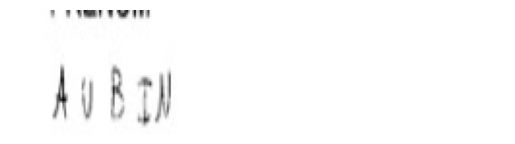

[3, 6, 4, 18, 5, 15, 14, 15, 22, 18, 9, 5, 22, 4, 14, 20, 14, 3, 6, 9, 4, 14, 6, 5, 15, 5, 5, 4, 7, 20, 11, 18, 5, 3, 14, 3, 7, 22, 3, 15, 15, 6, 9, 9, 3, 5, 21, 5, 15, 14, 8, 21, 3, 9, 14, 18, 9, 13, 18, 14, 14, 7, 28, 14, 11, 20, 4, 9, 3, 5, 22, 5, 15, 17, 10, 12, 15, 28, 3, 21, 3, 15, 14, 14, 15, 5, 20, 5, 9, 15, 13, 15, 20, 4, 8, 12, 14, 14, 28, 6, 14, 4, 4, 3, 6, 9, 3, 3, 21, 21, 3, 22, 14, 15, 18, 7, 15, 20, 16, 3, 3, 16, 3, 14, 4, 5, 18, 8]


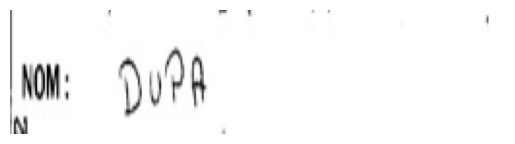

[23, 23, 3, 3, 10, 3, 11, 3, 10, 3, 7, 10, 10, 14, 23, 7, 7, 6, 23, 23, 17, 17, 7, 10, 3, 11, 3, 17, 21, 17, 20, 3, 3, 14, 23, 14, 15, 23, 26, 3, 3, 7, 23, 23, 14, 14, 3, 3, 3, 3, 3, 17, 16, 23, 23, 3, 23, 3, 23, 3, 12, 14, 14, 11, 6, 17, 3, 3, 15, 3, 20, 17, 3, 20, 3, 23, 3, 3, 27, 22, 6, 3, 23, 7, 3, 17, 17, 3, 23, 7, 3, 3, 11, 7, 17, 23, 7, 7, 3, 23, 7, 7, 3, 24, 3, 3, 20, 16, 11, 3, 14, 3, 7, 3, 3, 16, 3, 11, 3, 26, 15, 0, 3, 3, 17, 27, 20, 7]


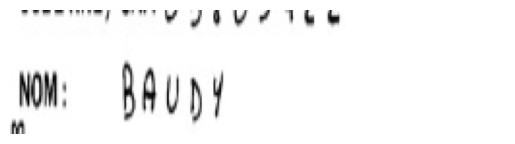

[4, 18, 23, 23, 14, 7, 3, 16, 17, 27, 16, 14, 7, 3, 16, 6, 17, 7, 5, 27, 11, 23, 21, 7, 22, 3, 16, 5, 16, 4, 3, 22, 18, 11, 13, 9, 15, 3, 7, 22, 26, 9, 11, 11, 7, 3, 14, 15, 6, 23, 22, 23, 11, 11, 5, 24, 22, 14, 5, 4, 3, 2, 11, 21, 4, 23, 18, 20, 3, 20, 23, 20, 23, 11, 15, 21, 22, 27, 6, 7, 7, 22, 5, 0, 20, 20, 15, 15, 7, 16, 21, 20, 24, 16, 16, 14, 0, 16, 16, 21, 9, 16, 18, 3, 24, 21, 22, 22, 15, 14, 11, 4, 14, 20, 23, 17, 7, 5, 28, 7, 4, 0, 14, 16, 23, 20, 11, 20]


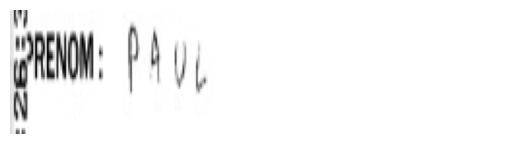

[11, 3, 6, 14, 17, 14, 11, 17, 15, 3, 22, 17, 17, 16, 3, 17, 0, 14, 20, 17, 21, 11, 20, 16, 10, 20, 22, 10, 3, 7, 28, 14, 23, 5, 3, 14, 3, 11, 14, 10, 7, 17, 14, 14, 26, 20, 3, 11, 3, 20, 17, 20, 21, 10, 11, 11, 10, 7, 10, 20, 11, 3, 9, 3, 7, 26, 22, 6, 23, 24, 17, 15, 10, 3, 6, 22, 10, 16, 11, 8, 14, 10, 4, 20, 12, 15, 3, 11, 20, 3, 21, 11, 7, 6, 22, 11, 9, 3, 9, 3, 20, 7, 22, 20, 11, 22, 23, 17, 17, 11, 28, 3, 11, 22, 14, 3, 14, 10, 3, 14, 20, 0, 11, 9, 15, 11, 9, 20]


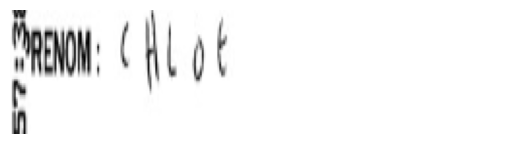

[16, 0, 27, 0, 7, 11, 9, 16, 3, 20, 11, 7, 0, 5, 0, 23, 0, 3, 17, 22, 21, 21, 17, 7, 11, 3, 7, 17, 23, 20, 3, 14, 5, 11, 21, 3, 0, 14, 14, 7, 16, 11, 14, 4, 0, 3, 15, 14, 14, 3, 23, 9, 21, 3, 7, 3, 0, 13, 17, 7, 5, 8, 10, 0, 16, 2, 11, 7, 20, 3, 16, 17, 17, 16, 3, 11, 27, 7, 16, 8, 21, 11, 7, 17, 17, 11, 16, 14, 11, 6, 3, 7, 14, 12, 3, 7, 17, 0, 0, 20, 3, 6, 11, 11, 6, 17, 21, 11, 16, 16, 7, 5, 17, 11, 0, 14, 27, 3, 20, 14, 17, 0, 27, 7, 7, 14, 7, 7]


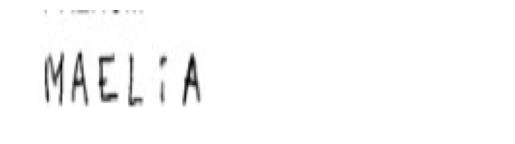

[0, 0, 0, 0, 0, 3, 20, 0, 21, 22, 14, 0, 0, 0, 0, 3, 0, 0, 21, 0, 11, 0, 23, 0, 14, 0, 18, 16, 14, 22, 4, 3, 11, 3, 0, 24, 0, 14, 7, 17, 5, 21, 7, 3, 0, 0, 17, 14, 11, 0, 15, 3, 3, 11, 0, 0, 0, 0, 22, 5, 0, 11, 0, 0, 27, 2, 21, 20, 27, 14, 9, 16, 23, 7, 17, 16, 21, 4, 0, 7, 17, 21, 20, 23, 20, 7, 7, 14, 16, 11, 16, 0, 0, 7, 11, 0, 8, 0, 0, 22, 16, 11, 21, 5, 0, 16, 0, 16, 0, 0, 7, 17, 0, 16, 0, 0, 21, 20, 7, 7, 11, 0, 3, 0, 6, 0, 16, 0]


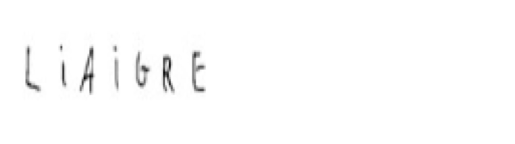

[0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 7, 0, 21, 0, 6, 0, 0, 0, 22, 0, 3, 20, 16, 0, 0, 7, 0, 17, 0, 0, 7, 0, 20, 23, 0, 0, 16, 3, 16, 0, 3, 16, 0, 20, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 3, 18, 22, 3, 0, 10, 0, 0, 20, 0, 23, 0, 0, 0, 0, 20, 16, 0, 22, 26, 11, 20, 0, 7, 0, 7, 6, 0, 0, 6, 16, 0, 8, 0, 0, 0, 6, 5, 22, 0, 0, 0, 0, 7, 0, 0, 0, 24, 0, 0, 0, 0, 0, 6, 22, 0, 21, 0, 10, 0, 11, 0, 22, 0]


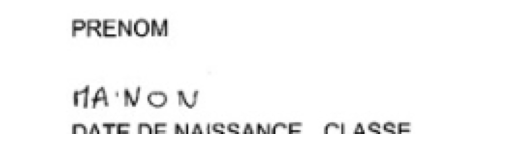

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 20, 0, 21, 0, 7, 0, 0, 0, 0, 0, 14, 6, 7, 0, 0, 0, 0, 16, 0, 0, 0, 0, 15, 6, 0, 0, 0, 0, 0, 0, 0, 17, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 10, 7, 7, 0, 0, 17, 0, 0, 3, 0, 11, 0, 0, 0, 0, 16, 0, 0, 0, 0, 7, 0, 0, 0, 0, 20, 20, 0, 0, 6, 7, 0, 0, 0, 0, 0, 0, 22, 3, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 21, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0]


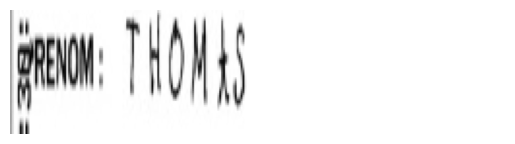

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 27, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0]


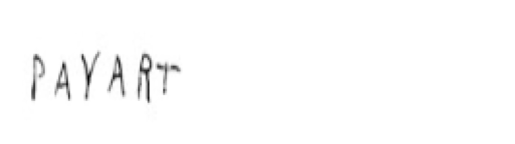

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0]
---------------------------


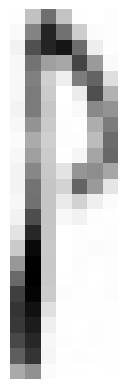

tensor([[254, 205, 139, 207, 254, 255, 253],
        [250, 156,  78, 141, 214, 251, 253],
        [244, 114,  79,  66, 137, 241, 253],
        [248, 142, 177, 184, 104, 173, 250],
        [249, 152, 216, 242, 150, 129, 228],
        [248, 148, 213, 255, 239, 112, 193],
        [245, 148, 209, 254, 250, 160, 168],
        [248, 168, 212, 253, 254, 189, 149],
        [251, 187, 216, 253, 253, 201, 136],
        [248, 177, 213, 254, 247, 182, 133],
        [246, 158, 210, 233, 169, 163, 183],
        [246, 142, 208, 220, 130, 173, 234],
        [248, 140, 208, 238, 218, 242, 251],
        [244, 111, 208, 249, 244, 253, 254],
        [232,  81, 209, 255, 253, 254, 253],
        [212,  57, 211, 255, 253, 251, 252],
        [172,  50, 210, 255, 252, 254, 253],
        [134,  49, 211, 254, 253, 255, 253],
        [100,  53, 213, 252, 254, 254, 252],
        [ 92,  63, 230, 254, 254, 254, 254],
        [ 95,  72, 242, 254, 255, 253, 254],
        [107,  81, 248, 253, 254, 253, 254],
        [1

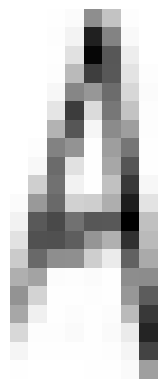

tensor([[255, 255, 254, 251, 152, 201, 253, 255],
        [255, 255, 253, 244,  52, 142, 249, 255],
        [255, 255, 254, 227,  28, 102, 238, 255],
        [255, 255, 253, 192,  79, 103, 229, 253],
        [255, 255, 247, 144, 160, 121, 218, 251],
        [255, 255, 231,  78, 222, 131, 200, 253],
        [255, 255, 185, 101, 246, 149, 166, 253],
        [255, 253, 141, 157, 254, 166, 130, 254],
        [255, 248, 120, 227, 254, 174, 100, 254],
        [255, 211, 125, 243, 254, 198,  74, 247],
        [251, 162, 119, 213, 210, 181,  49, 230],
        [243, 104,  89, 126, 102, 103,  22, 197],
        [228,  96,  95, 108, 158, 183,  66, 192],
        [207, 119, 152, 153, 210, 236, 111, 177],
        [182, 171, 252, 253, 251, 254, 151, 150],
        [156, 215, 254, 254, 253, 254, 160, 106],
        [174, 241, 254, 252, 254, 252, 192,  73],
        [219, 253, 253, 250, 254, 250, 236,  56],
        [245, 254, 254, 254, 254, 253, 245,  83],
        [254, 255, 255, 255, 254, 254, 250, 167]],

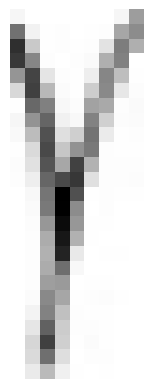

tensor([[246, 255, 255, 255, 255, 255, 255, 246, 159],
        [117, 242, 254, 253, 255, 254, 253, 168, 142],
        [ 51, 202, 254, 253, 254, 253, 227, 128, 176],
        [ 60, 136, 253, 255, 253, 250, 176, 131, 255],
        [151,  72, 229, 253, 254, 238, 136, 191, 254],
        [216,  68, 185, 251, 254, 206, 139, 231, 252],
        [254, 107, 130, 248, 252, 164, 171, 253, 250],
        [246, 150, 104, 241, 248, 132, 209, 252, 251],
        [249, 189,  86, 223, 208, 118, 235, 254, 253],
        [254, 218,  78, 199, 148, 124, 253, 254, 254],
        [252, 225,  88, 169,  69, 179, 253, 253, 253],
        [253, 238, 105,  78,  59, 224, 253, 253, 252],
        [255, 248, 120,   5,  84, 254, 253, 254, 254],
        [255, 250, 125,   6, 142, 255, 253, 255, 255],
        [255, 252, 153,  16, 153, 254, 254, 255, 255],
        [255, 253, 173,  28, 178, 254, 255, 255, 255],
        [255, 253, 178,  40, 233, 255, 254, 254, 255],
        [255, 253, 173, 113, 248, 255, 255, 255, 255],
        [2

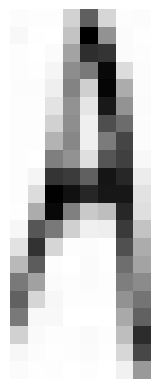

tensor([[252, 253, 253, 217, 120, 220, 253, 252],
        [249, 254, 255, 204,  40, 163, 251, 254],
        [253, 255, 251, 177,  79,  84, 251, 253],
        [253, 254, 246, 159, 143,  48, 225, 252],
        [252, 252, 241, 151, 214,  45, 185, 252],
        [253, 253, 232, 163, 233,  61, 165, 251],
        [253, 253, 216, 160, 241, 106, 131, 252],
        [253, 253, 192, 154, 241, 144,  98, 252],
        [253, 255, 147, 163, 228, 112,  94, 249],
        [253, 246,  85,  90, 121,  58,  73, 239],
        [253, 225,  41,  55,  72,  60,  60, 230],
        [254, 185,  47, 148, 209, 200,  73, 228],
        [248, 113, 142, 215, 242, 240,  89, 204],
        [230,  82, 220, 253, 252, 254, 108, 185],
        [196, 118, 253, 255, 251, 254, 133, 178],
        [142, 176, 251, 253, 251, 253, 146, 157],
        [123, 220, 248, 253, 253, 253, 163, 138],
        [142, 249, 249, 255, 255, 255, 182, 122],
        [216, 250, 253, 253, 250, 253, 200,  77],
        [248, 252, 254, 253, 251, 254, 221, 100],


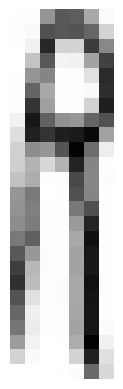

tensor([[254, 254, 160, 105, 110, 178, 251],
        [254, 250, 100, 104, 102, 118, 216],
        [254, 242,  61, 216, 215,  81, 148],
        [255, 202, 104, 244, 242, 173,  85],
        [254, 160, 145, 254, 253, 228,  64],
        [253, 117, 178, 253, 253, 249,  68],
        [253,  73, 170, 254, 254, 215,  54],
        [242,  47, 113, 155, 161, 116,  99],
        [225,  56,  72,  54,  51,  35, 171],
        [213, 153, 161, 102,  29, 124, 239],
        [212, 186, 219, 187,  58, 145, 253],
        [200, 181, 254, 253,  92, 147, 252],
        [161, 136, 255, 254, 100, 145, 254],
        [158, 140, 253, 254, 134,  98, 254],
        [153, 137, 253, 253, 163,  59, 254],
        [136, 112, 254, 254, 178,  41, 254],
        [105, 162, 252, 254, 173,  47, 254],
        [ 82, 190, 252, 254, 173,  48, 254],
        [ 70, 195, 254, 252, 177,  42, 253],
        [101, 228, 254, 252, 177,  44, 254],
        [118, 240, 254, 253, 175,  46, 254],
        [131, 238, 254, 254, 173,  45, 251],
        [1

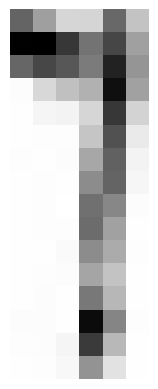

tensor([[138, 182, 224, 223, 141, 210],
        [ 63,  62, 104, 149, 115, 183],
        [139, 116, 128, 155,  88, 175],
        [252, 225, 207, 196,  74, 184],
        [254, 247, 246, 224, 104, 222],
        [254, 253, 253, 211, 124, 239],
        [253, 254, 252, 188, 136, 246],
        [254, 253, 254, 168, 138, 248],
        [254, 253, 255, 147, 164, 252],
        [254, 253, 253, 144, 184, 254],
        [254, 254, 251, 168, 191, 253],
        [254, 253, 252, 187, 210, 254],
        [254, 252, 254, 153, 200, 254],
        [252, 252, 254,  71, 163, 253],
        [253, 252, 247, 106, 201, 254],
        [254, 253, 249, 174, 233, 254]], dtype=torch.uint8)


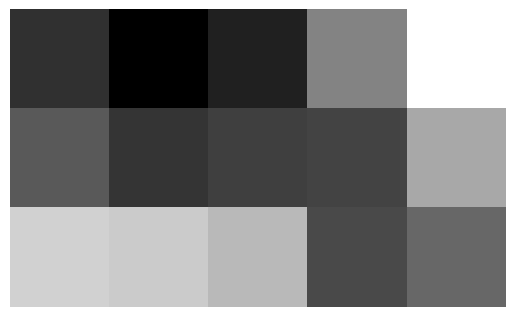

tensor([[ 97,  62,  85, 156, 243],
        [126, 100, 107, 110, 181],
        [210, 206, 193, 114, 135]], dtype=torch.uint8)


AttributeError: 'list' object has no attribute 'view'

In [206]:
batch_size = 1
num_epochs = 10

losses = []
for epoch in range(num_epochs):
    modelRNN.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for idx, (images, labels) in enumerate(train_loader2):
        state = modelRNN.init_hidden(batch_size)
        optimizer.zero_grad()


        #print(images)
        for i, l in zip(images, labels):
            image_to_show = i.squeeze().numpy()
            plt.imshow(image_to_show, cmap='gray')
            plt.axis('off')
            plt.show()

            img, t = segment_letters(i, l)
            if t == False:
                continue
            else:
              #print(img)
              print("---------------------------")
              # Mostrar la imagen segmentada
              for imgag in img:
                    # Mostrar la imagen segmentada
                    plt.imshow(imgag, cmap='gray')
                    plt.axis('off')
                    plt.show()
                    print(imgag)





            img = img.view(-1, H, W, C)
            features = SimpleCNN(img)
            features = features.view(1, -1, input_dim)

            outputs = modelRNN(features)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Guardar el modelo entrenado
torch.save(modelRNN.state_dict(), 'rnn_model.pth')

In [ ]:
def compare_letter_pairs(true_labels, predicted_labels):
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Les llistes han de tenir la mateixa longitud")

    total_pairs = len(true_labels)
    same_letter_count = 0
    total_letters = 0

    for label1, label2 in zip(true_labels, predicted_labels):
        if label1 == label2:
            same_letter_count += 1

        total_letters += 1

    letter_percentage = (same_letter_count / total_letters) * 100

    return same_letter_count, letter_percentage

# Exemple d'ús amb les prediccions del model
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in validation_generator:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

same_letter_count, letter_percentage = compare_letter_pairs(true_labels, predicted_labels)
print(f'Nombre de lletres correctes: {same_letter_count}')
print(f'Percentatge de lletres correctes: {letter_percentage}%')

Nombre de lletres correctes: 17766
Percentatge de lletres correctes: 90.80036798528059%
